In [1]:
!pip install numpy SimpleITK plyfile scipy opencv-python tensorflow keras 
!apt-get update
!apt-get install -y xvfb libgl1-mesa-glx
# Example volume ID; used throughout the notebook
volume_id = 4

  Using cached MarkupSafe-3.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (20 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Hit:1 http://deb.debian.org/debian bullseye InRelease
Hit:2 http://deb.debian.org/debian-security bullseye-security InRelease
Hit:3 http://deb.debian.org/debian bullseye-updates InRelease




libgl1-mesa-glx is already the newest version (20.3.5-1).
xvfb is already the newest version (2:1.20.11-1+deb11u14).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [2]:
# create mhd file for a single raw file
def create_mhd_file(str):  # Updated path
    """
    Create a .mhd metadata file for a given .raw volume file
    """
    mhd_content = f"""ObjectType = Image
        NDims = 3
        BinaryData = True
        BinaryDataByteOrderMSB = False
        CompressedData = False
        TransformMatrix = 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0
        Offset = 0.0 0.0 0.0
        CenterOfRotation = 0.0 0.0 0.0
        AnatomicalOrientation = RAI
        ElementSpacing = 0.49479 0.49479 0.3125
        DimSize = 768 768 1280
        ElementType = MET_USHORT
        ElementDataFile = {str}"""  # This now includes the train_raw directory
    
    with open(f"scan_{volume_id:03}.mhd", 'w') as f:
        f.write(mhd_content)
    print(f"Created scan_{volume_id:03}.mhd with updated path to raw file")

# Create the .mhd file
create_mhd_file(f"raw_files/scan_{volume_id:03}.raw")

Created scan_004.mhd with updated path to raw file


In [3]:
# Loading the volume (raw file) through the generated mhd file above
# right now just loading a single file (scan_001)
import SimpleITK as sitk
import numpy as np

def load_volume(volume_id: int) -> np.ndarray:
    """
    Load a single ultrasound volume from .mhd file
    Args:
        volume_id: ID number of the volume to load (1-5 for labeled data)
    Returns:
        3D numpy array containing ultrasound data
    """
    filename = f"scan_{volume_id:03d}.mhd"
    
    try:
        # Read the .mhd file using SimpleITK
        header = sitk.ReadImage(filename)
        
        # Convert SimpleITK image to numpy array
        volume = sitk.GetArrayFromImage(header)
        
        # Print volume shape and info to verify dimensions
        print(f"Loaded volume shape: {volume.shape}")
        print(f"Data type: {volume.dtype}")
        print(f"Value range: [{volume.min()}, {volume.max()}]")
        
        return volume
        
    except Exception as e:
        print(f"Error loading volume: {e}")
        return None

# 1280 slices, each 768*768 picels
# current value range 0-38685, we need to normalize to 0-1
volume_data = load_volume(volume_id)

Loaded volume shape: (1280, 768, 768)
Data type: uint16
Value range: [0, 37841]


In [4]:
# Resized each slice from 768*768 to 256*256 because raw file too big (what they did in the report)
# Converted to float32 and normalized value range to 0-1

import numpy as np
from scipy.ndimage import zoom


def preprocess_volume(volume: np.ndarray, target_size: tuple = (256, 256)) -> np.ndarray:
    
    """
    Preprocess the volume by downsampling and normalizing using scipy
    Args:
        volume: Input volume of shape (1280, 768, 768)
        target_size: Desired size for each slice (width, height)
    Returns:
        Preprocessed volume
    """

    # Calculate zoom factors
    zoom_factors = (1,  # Don't change number of slices
                   target_size[0] / volume.shape[1],  # height scale
                   target_size[1] / volume.shape[2])  # width scale
    
    print("Resizing volume...")
    # Resize the volume using scipy zoom
    processed_volume = zoom(volume, zoom_factors, order=1)
    
    print("Normalizing values...")
    # Normalize to [0,1]
    processed_volume = processed_volume.astype(np.float32)  # Convert to float32 first
    processed_volume = (processed_volume - processed_volume.min()) / (processed_volume.max() - processed_volume.min())
    
    # Print info about processed volume
    print(f"Processed volume shape: {processed_volume.shape}")
    print(f"Processed data type: {processed_volume.dtype}")
    print(f"Processed value range: [{processed_volume.min()}, {processed_volume.max()}]")
    
    return processed_volume


# Example usage:
if __name__ == "__main__":
    # Assuming we have loaded volume_data from previous step
    processed_volume = preprocess_volume(volume_data)

Resizing volume...
Normalizing values...
Processed volume shape: (1280, 256, 256)
Processed data type: float32
Processed value range: [0.0, 1.0]


In [5]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('trained_model_reduced.h5')

# Load the processed volume
processed_volume = np.load('train_x/scan_002_processed_volume.npy')

# Check the shape of processed_volume
print(f"Original processed_volume shape: {processed_volume.shape}")

# Reshape it assuming the first dimension is the number of slices
# We'll take each slice (256x256) as a separate example and add a channel dimension
num_slices = processed_volume.shape[0]
processed_volume = processed_volume.reshape((num_slices, 256, 256, 1))

# Predict using the model
prediction = model.predict(processed_volume)
prediction

2024-11-17 08:18:58.284364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 08:18:58.392308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-17 08:18:58.392329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-17 08:18:58.413007: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 08:18:58.981930: W tensorflow/stream_executor/platform/de

array([[[[1.5897101e-02],
         [2.9124154e-03],
         [6.8757306e-03],
         ...,
         [1.0982599e-05],
         [6.2897854e-04],
         [1.1549268e-03]],

        [[1.2175118e-03],
         [2.3484475e-03],
         [5.5654038e-04],
         ...,
         [2.8881870e-04],
         [8.4619399e-04],
         [1.6496885e-04]],

        [[1.9376396e-03],
         [6.7243673e-04],
         [7.8801510e-05],
         ...,
         [8.3255972e-12],
         [2.2951521e-07],
         [7.5597978e-05]],

        ...,

        [[6.1750456e-05],
         [1.5583842e-07],
         [2.8107861e-08],
         ...,
         [9.9253328e-10],
         [5.7497323e-11],
         [1.3934671e-07]],

        [[3.6878348e-04],
         [3.8693150e-04],
         [7.7683356e-04],
         ...,
         [1.1353395e-12],
         [5.4483365e-08],
         [8.3977202e-06]],

        [[4.2425925e-03],
         [2.2586503e-06],
         [2.8748319e-03],
         ...,
         [1.6879403e-13],
        

In [8]:
from plyfile import PlyElement, PlyData 
# The prediction array has an extra dimension for the channel, which we need to remove.
# We will reshape the prediction array to remove the channel dimension.

# Remove the channel dimension
prediction_reshaped = prediction.reshape((1280, 256, 256))

def numpy_to_ply(prediction, filename):
    # Flatten the prediction array and get all indices
    indices = np.argwhere(prediction > 0.5)  # Get all indices where prediction is non-zero
    
    # Create a list of vertices
    vertices = [(x, y, z) for x, y, z in indices]
    
    # Define the PLY vertex element
    vertex = np.array(vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    el = PlyElement.describe(vertex, 'vertex')
    
    # Write to a PLY file
    PlyData([el], text=True).write(filename)

# Convert the reshaped prediction to PLY with filename based on volume_id
ply_filename = f'prediction_output_{volume_id:03}.ply'
numpy_to_ply(prediction_reshaped, ply_filename)

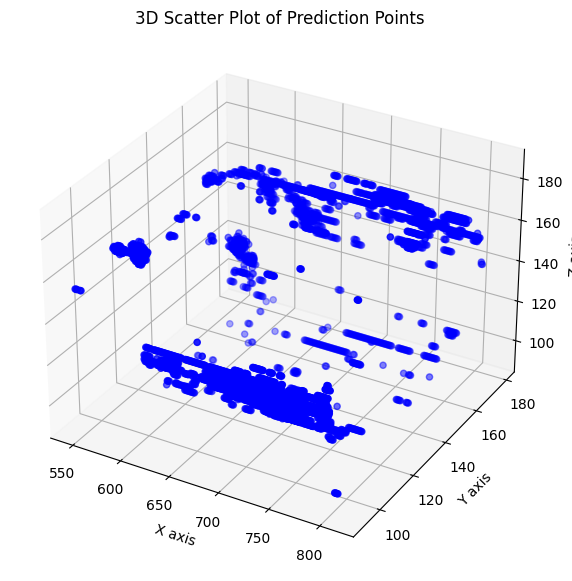

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
prediction_reshaped = prediction.reshape((1280, 256, 256))

# Extract all indices from prediction_reshaped
indices = np.argwhere(prediction_reshaped > 0.5)

# Plot the points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:, 0], indices[:, 1], indices[:, 2], c='b', marker='o')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot of Prediction Points')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee6345b0-5b50-4d75-aba3-45baad6d02c9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>